In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, BaseMessage
import operator
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver # A simple in-memory checkpointer that saves the state of the workflow at each step.

In [5]:
load_dotenv()

True

In [6]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)

In [ ]:
from langgraph.graph.message import add_messages
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
# add_messages is a helper function / reducer that adds messages to the state.
#  It takes care of appending new messages to the existing list of messages in the state.

In [8]:
def chat_node(state: ChatState):

    # prepare the prompt
    prompt = state["messages"]

    # call the llm model
    response =model.invoke(prompt)

    # parse the response and update the state
    return { 'messages': [response]}


In [ ]:
checkpointer = MemorySaver() # a checkpointer instance to save the state of the workflow at each step.
 # This allows us to inspect the state after execution and also to resume from a specific point if needed.
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)

graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", END)

workflow = graph.compile(checkpointer=checkpointer)

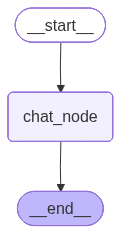

In [20]:
workflow

In [27]:
# initial_state = {
#     'messages': [HumanMessage(content='What is the capital of india')]
# }
# final_state = workflow.invoke(initial_state)['messages'][1].content 
# print(final_state)

In [26]:
thread_id = 1
while True:
    messages = input("Type here")
    if messages.strip().lower() in ['exit', 'quit', 'bye']:
        break

    config = {
        "configurable": {
            "thread_id": thread_id
        }
    }
    response = workflow.invoke({"messages": [HumanMessage(content=messages)]}, config=config)

    print("AI:", response['messages'][-1].content)

In [24]:
workflow.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi, I am Jyoti ', additional_kwargs={}, response_metadata={}, id='cf5080a2-71fa-45f8-8a7a-0fb734e38974'), AIMessage(content='Hi Jyoti! Nice to meet you.\n\nHow can I assist you today?', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c7a96-2856-72e3-83e1-f4a96e84a244-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 8, 'output_tokens': 417, 'total_tokens': 425, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 400}}), HumanMessage(content="What's my name ?", additional_kwargs={}, response_metadata={}, id='ca2f5066-93bc-4f55-9266-1ab4fad04b73'), AIMessage(content='Your name is Jyoti! You told me that when we first started chatting.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'm

In [ ]:
# Using this config, the workflow will save the state of the conversation at each step with the associated thread_id. 
# This allows us to keep track of multiple conversations and their states separately.
# Everytime we invoke the workflow with a specific thread_id, it will update the state for that thread_id in the checkpointer at the end of each step.